This notebook contains code used in part 2 of British Airways data analysis job simulation on Forage. 
Libraries utilized: pandas, numpy, matplotlib, sklearn

In [1]:
#!/.venv/bin/python3

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, confusion_matrix

/var/folders/4q/3hpsmm7139xd1jt2kz8jxjrc0000gn/T/ipykernel_29835/1376896036.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [6]:
# Read reviews into dataframe
df = pd.read_csv("data/customer_booking.csv", encoding="ISO-8859-1")

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


In [7]:
# Encode 'flight_day' as a number. We will take care of rest of categorical
# features below

mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}
df["flight_day"] = df["flight_day"].map(mapping)

df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5])

In [8]:
# Now really prepare the data. Categorical features must be encoded to numbers of some kind

# Split data into x and y
y = df['booking_complete']
x = df.drop(['booking_complete'], axis= 1)

# Encode categorical columns
le = LabelEncoder()
x['sales_channel'] = le.fit_transform(x['sales_channel'])
x['trip_type'] = le.fit_transform(x['trip_type'])
x['route'] = le.fit_transform(x['route'])
x['booking_origin'] = le.fit_transform(x['booking_origin'])

# Split into training and testing
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size= .20, random_state= 100)

print(f'x-train shape: {X_train.shape}')
print(f'x-test shape: {X_test.shape}')

x-train shape: (40000, 13)
x-test shape: (10000, 13)


In [9]:
# Fit forest
forest = RandomForestClassifier()
forest.fit(X_train, y_train)

# Output the feature importances the model calculated
display(forest.feature_importances_)

array([0.04988885, 0.01247604, 0.00179253, 0.19361221, 0.12676921,
       0.14094559, 0.09063016, 0.15051182, 0.11023609, 0.01462033,
       0.01635286, 0.02089507, 0.07126926])

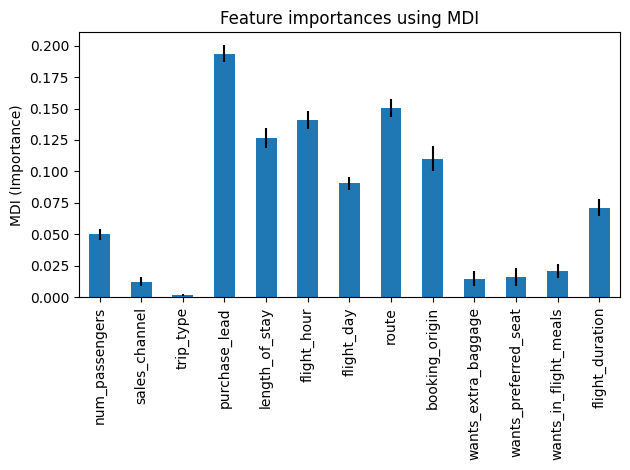

In [10]:
# Chart feature importances and standard devs
importances = forest.feature_importances_
imp_stds = np.std([tree.feature_importances_ for tree in forest.estimators_], axis= 0)

feature_names = [feat for feat in x.columns]
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr= imp_stds, ax= ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("MDI (Importance)")
fig.tight_layout()

In [11]:
# Run prediction on test data, check accuracy
y_pred_test = forest.predict(X_test)
print(f'accuracy_score: {accuracy_score(y_test, y_pred_test)}')
print(f'f1_scores: {f1_score(y_test, y_pred_test, average=None)}')

accuracy_score: 0.852
f1_scores: [0.91867238 0.17869034]


In [13]:
# Cross validation and confusion matrix for additional analysis,
# feature revision, parameter adjustment, etc
scores = cross_val_score(forest, x, y, cv=5)
print(f'{scores.mean():.2f} 5 K-Fold accuracy with a standard dev. of {scores.std():.2f}')
display(scores)

0.48 5 K-Fold accuracy with a standard dev. of 0.20


array([0.851 , 0.4222, 0.2563, 0.3706, 0.5176])

In [14]:
confusion_matrix(y_test, y_pred_test)

array([[8359,  148],
       [1332,  161]])